### Test2

In [1]:
print("a")

a


1. 関数定義

In [1]:
# ================================
# Cell 1 — 関数定義（I/O・前処理・QRC・外生特徴・学習・可視化）
# ================================
import os, re, time, math, pathlib
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# ---------- ユーティリティ ----------
class Timer:
    def __init__(self, label=""): self.label = label
    def __enter__(self): self.t0 = time.perf_counter(); return self
    def __exit__(self, *exc): 
        dt = time.perf_counter() - self.t0
        if self.label: print(f"[TIMER] {self.label}: {dt:.2f}s")

def rmse_(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def ensure_outdir():
    win_dir = r"C:\qiskit-python\QFF2025\outputs\QRC"
    posix_dir = "./outputs/QRC"
    outdir = win_dir if os.name == "nt" else posix_dir
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    print(f"[IO] Export directory = {outdir}")
    return outdir

def savefig(path, dpi=300):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[SAVE] {path}")
    plt.show()

def save_table(df: pd.DataFrame, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(path, index=False)
    print(f"[SAVE] {path}")

# ---------- データ読み込み ----------
HEADER_BIPAT = r"Tenor\s*:\s*([0-9.+\-eE]+)\s*;\s*Maturity\s*:\s*([0-9.+\-eE]+)"
TENOR_PAT   = r"Tenor\s*:\s*([0-9.+\-eE]+)(?=\s*;)"
MATU_PAT    = r"Maturity\s*:\s*([0-9.+\-eE]+)"

def read_swaption_csv_with_mask(csv_path: str):
    df = pd.read_csv(csv_path, engine="python", sep=None)
    date_col = None
    for c in df.columns[::-1]:
        if str(c).strip().lower() == "date":
            date_col = c; break
    if date_col is None: date_col = df.columns[-1]
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    feature_cols = [c for c in df.columns if c != date_col]
    df_num = df.copy()
    df_num[feature_cols] = df_num[feature_cols].apply(pd.to_numeric, errors="coerce")
    mask_obs = ~df_num[feature_cols].isna().values
    df_filled = df_num.copy()
    df_filled[feature_cols] = df_filled[feature_cols].ffill().bfill()
    return df_filled, date_col, feature_cols, mask_obs

# --- 外生（HAR）特徴の読み込み＆整形（存在しないときはNoneを返す） ---
def read_exog_features(exog_csv_path: str,
                       date_col_name: str = "Date",
                       drop_cols: List[str] = ("TARGET",)):
    if not os.path.exists(exog_csv_path):
        print(f"[INFO] exog file not found: {exog_csv_path} (skip)")
        return None
    ex = pd.read_csv(exog_csv_path)
    if date_col_name not in ex.columns:
        # 最右列がDate想定の救済
        cand = [c for c in ex.columns if str(c).strip().lower()=="date"]
        date_col_name = cand[0] if cand else ex.columns[0]
    ex[date_col_name] = pd.to_datetime(ex[date_col_name], errors="coerce")
    for d in drop_cols:
        if d in ex.columns: ex = ex.drop(columns=[d])
    # 数値化
    num_cols = [c for c in ex.columns if c != date_col_name]
    ex[num_cols] = ex[num_cols].apply(pd.to_numeric, errors="coerce")
    return ex, date_col_name

def align_and_make_exog_matrix(df_base: pd.DataFrame, DATE_COL: str,
                               exog_df: pd.DataFrame, exog_date_col: str,
                               use_cols: Optional[List[str]] = None,
                               fill_method: str = "ffill_bfill"):
    # 左結合でDateを合わせ、欠損は前方/後方/0で埋める
    base = df_base[[DATE_COL]].copy()
    ex = exog_df.copy()
    if use_cols is not None:
        keep = [c for c in use_cols if c in ex.columns]
    else:
        keep = [c for c in ex.columns if c != exog_date_col]
    merged = base.merge(ex[[exog_date_col]+keep], how="left",
                        left_on=DATE_COL, right_on=exog_date_col)
    merged = merged.drop(columns=[exog_date_col])
    if fill_method:
        if "ffill" in fill_method: merged[keep] = merged[keep].ffill()
        if "bfill" in fill_method: merged[keep] = merged[keep].bfill()
    merged[keep] = merged[keep].fillna(0.0)
    X_exog = merged[keep].values.astype(float)  # (T, D)
    return X_exog, keep

def make_exog_design_for_forecast(X_exog_all: np.ndarray, W: int, H: int,
                                  lags: List[int], N_all_fore: int):
    """
    予測ベース時刻 t (= W .. T-H-1) の exog[t - lag] を横に連結。
    出力: (N_all_fore, D * len(lags))
    """
    T, D = X_exog_all.shape
    feats = np.zeros((N_all_fore, D*len(lags)), float)
    for i in range(N_all_fore):
        t = W + i
        offs = 0
        for L in lags:
            tL = max(0, t - L)  # 念のため下限クランプ
            feats[i, offs:offs+D] = X_exog_all[tL]
            offs += D
    return feats  # (N_all_fore, D*|lags|)

# ---------- Tenor/Maturity 解析と因子基底 ----------
def parse_tenor_maturity_from_headers(cols: List[str]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    T_list, M_list, bad = [], [], []
    for c in cols:
        s = str(c)
        m = re.search(HEADER_BIPAT, s)
        if m:
            t = float(m.group(1).strip(" ,;")); u = float(m.group(2).strip(" ,;"))
        else:
            m1 = re.search(TENOR_PAT, s); m2 = re.search(MATU_PAT, s)
            if m1 and m2:
                t = float(m1.group(1).strip(" ,;"))
                u = float(m2.group(1).strip(" ,;"))
            else:
                nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
                if len(nums) >= 2: t, u = float(nums[0]), float(nums[1])
                else: t, u = np.nan, np.nan; bad.append(s)
        T_list.append(t); M_list.append(u)
    if bad: print(f"[WARN] Tenor/Maturity parse failed for {len(bad)} cols (ex: {bad[:3]})")
    return np.array(T_list, float), np.array(M_list, float), np.arange(len(cols))

def _normalize_pm1(x: np.ndarray):
    x = np.asarray(x, float)
    mn, mx = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(mn) or not np.isfinite(mx) or mx == mn: return np.zeros_like(x)
    return 2.0*(x - mn)/(mx - mn) - 1.0

def build_phi_poly2(tenors: np.ndarray, maturities: np.ndarray, include_cross=True):
    Tn = _normalize_pm1(tenors); Mn = _normalize_pm1(maturities)
    parts = [np.ones_like(Tn), Tn, Mn, Tn**2, Mn**2]
    names = ["1", "T", "M", "T2", "M2"]
    if include_cross: parts.append(Tn*Mn); names.append("TxM")
    Phi = np.vstack(parts).T  # (F, K)
    Phi[~np.isfinite(Phi)] = 0.0
    return Phi, names

def pinv_colwise(Phi: np.ndarray) -> np.ndarray:
    return np.linalg.pinv(Phi)  # (K, F)

def project_to_beta(X_scaled_all: np.ndarray, A: np.ndarray) -> np.ndarray:
    # (T,F) × (F,K)^T → (T,K)
    return X_scaled_all @ A.T

def reconstruct_from_beta(beta_like: np.ndarray, Phi: np.ndarray) -> np.ndarray:
    shp = beta_like.shape
    K = Phi.shape[1]
    b2 = beta_like.reshape(-1, K) @ Phi.T
    F = Phi.shape[0]
    return b2.reshape(*(shp[:-1]), F)

# ---------- スケーラ / PCA / ウィンドウ ----------
def fit_scaler(X_all: np.ndarray, cut_train_end: int):
    scaler = StandardScaler().fit(X_all[:cut_train_end])
    X_scaled_all = scaler.transform(X_all)
    return scaler, X_scaled_all

def fit_pca_for_beta(beta_all: np.ndarray, cut_train_end: int, n_qubits: int):
    n_components_eff = min(n_qubits, beta_all.shape[1], max(1, beta_all[:cut_train_end].shape[0]-1))
    pca = PCA(n_components=n_components_eff, random_state=42).fit(beta_all[:cut_train_end])
    B_reduced_all = pca.transform(beta_all)
    return pca, B_reduced_all

def make_windows(X_any_all: np.ndarray, W: int) -> np.ndarray:
    out = []
    for t in range(W, len(X_any_all)):
        out.append(X_any_all[t-W:t])
    return np.asarray(out, float)  # (T-W, W, dim)

# ---------- 目的（β空間の Δ or level） ----------
def build_targets_beta(beta_all: np.ndarray, W: int, H: int, target_mode="delta"):
    T, K = beta_all.shape
    idx = []; Ys = []; bases = []
    for t in range(W, T - H):
        base = beta_all[t]
        ys = []
        for h in range(1, H+1):
            y = beta_all[t+h]
            ys.append(y - base if target_mode == "delta" else y)
        idx.append(t); Ys.append(np.stack(ys, axis=0)); bases.append(base)
    return np.array(idx, int), np.asarray(Ys, float), np.asarray(bases, float)

# ---------- QRC（Statevectorでエンコード） ----------
@dataclass
class QRCParams:
    n_qubits: int = 6
    depth: int = 2
    kappa_in: float = 1.0
    seed: int = 7

def _mix_layer(qc: QuantumCircuit, params: QRCParams):
    n, d = params.n_qubits, params.depth
    for _ in range(d):
        for q in range(n): qc.rz((q+1)*0.07, q)
        for q in range(n-1): qc.cx(q, q+1)
        qc.cx(n-1, 0)
        for q in range(n): qc.rx((q+1)*0.13, q)

def _z_or_pair(sv: Statevector, n_qubits: int, use_pair: bool):
    probs = sv.probabilities_dict()
    expZ = np.zeros(n_qubits)
    for bit, p in probs.items():
        br = bit[::-1]
        for i in range(n_qubits):
            expZ[i] += p*(+1.0 if br[i]=='0' else -1.0)
    if not use_pair: return expZ
    zz = []
    for i in range(n_qubits):
        for j in range(i+1, n_qubits):
            acc = 0.0
            for bit, p in probs.items():
                br = bit[::-1]
                zi = +1.0 if br[i]=='0' else -1.0
                zj = +1.0 if br[j]=='0' else -1.0
                acc += p*(zi*zj)
            zz.append(acc)
    return np.concatenate([expZ, np.asarray(zz, float)])

def qrc_features_timesliced(windows_r: np.ndarray, params: QRCParams, use_pair=False):
    # 各スライス毎に <Z>（＋任意でZZ）を取得し、時系列連結
    N, W, n = windows_r.shape
    D1 = n if not use_pair else n + n*(n-1)//2
    feats = np.empty((N, W*D1), float)
    for k in range(N):
        qc = QuantumCircuit(n, name="qrc_ts")
        offs = 0
        for s in range(W):
            for q in range(n):
                angle = params.kappa_in * windows_r[k, s, q]
                qc.ry(angle, q)
            _mix_layer(qc, params)
            sv = Statevector.from_instruction(qc)
            feats[k, offs:offs+D1] = _z_or_pair(sv, n, use_pair)
            offs += D1
    return feats  # (N, W*D1)

def standardize_features(X_feats: np.ndarray, idx_train: slice):
    tr = X_feats[idx_train]
    mu = tr.mean(axis=0)
    sd = tr.std(axis=0); sd[sd==0]=1.0
    def _tfm(x): return (x - mu)/sd
    return _tfm

# ---------- Δβ→価格スケールに戻す ----------
def make_reconstructor_for_price(scaler_X: StandardScaler, Phi: np.ndarray, apply_log1p: bool):
    def to_price_from_beta(y_like, base_beta=None, mode="delta"):
        if y_like.ndim == 2:
            Nloc, K = y_like.shape
            yb = (base_beta + y_like) if mode=="delta" else y_like
            v_scaled = reconstruct_from_beta(yb, Phi)
            v_unscaled = scaler_X.inverse_transform(v_scaled)
            v_price = np.expm1(v_unscaled) if apply_log1p else v_unscaled
            return np.clip(v_price, 0.0, None)
        else:
            Nloc, Hloc, K = y_like.shape
            yb = (base_beta[:, None, :] + y_like) if mode=="delta" else y_like
            v_scaled = reconstruct_from_beta(yb, Phi)
            v_unscaled = scaler_X.inverse_transform(v_scaled.reshape(Nloc*Hloc, -1)).reshape(Nloc, Hloc, -1)
            v_price = np.expm1(v_unscaled) if apply_log1p else v_unscaled
            return np.clip(v_price, 0.0, None)
    return to_price_from_beta

# ---------- 可視化 ----------
def parity_plot(y_true: np.ndarray, y_pred: np.ndarray, title: str="Parity"):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true.ravel(), y_pred.ravel(), s=6, alpha=0.4)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, '--', linewidth=1)
    plt.title(title); plt.xlabel("True"); plt.ylabel("Pred"); plt.grid(True)

def error_hist(y_true: np.ndarray, y_pred: np.ndarray, title="Error histogram"):
    err = (y_pred - y_true).ravel()
    plt.figure(figsize=(6,3))
    plt.hist(err, bins=60, alpha=0.8)
    plt.title(title); plt.xlabel("Pred - True"); plt.ylabel("count"); plt.grid(True)

def rmse_heatmap_by_grid(y_true: np.ndarray, y_pred: np.ndarray, feature_cols: List[str], title="RMSE heatmap"):
    from collections import defaultdict
    err2 = (y_true - y_pred)**2
    rmse_vec = np.sqrt(err2.mean(axis=0))  # (F,)
    tenors, maturities, _ = parse_tenor_maturity_from_headers(feature_cols)
    valid = np.isfinite(tenors) & np.isfinite(maturities)
    rmse_v = rmse_vec[valid]
    T_v = np.round(tenors[valid], 12); M_v = np.round(maturities[valid], 12)
    idx_by_pair = defaultdict(list)
    for i, (t, m) in enumerate(zip(T_v, M_v)):
        idx_by_pair[(float(t), float(m))].append(i)
    unique_pairs = sorted(idx_by_pair.keys())
    T_vals = sorted({t for (t, _) in unique_pairs})
    M_vals = sorted({m for (_, m) in unique_pairs})
    Tn, Mn = len(T_vals), len(M_vals); U = len(unique_pairs)
    if Tn * Mn == U and Tn>0 and Mn>0:
        pos_T = {t: i for i, t in enumerate(T_vals)}
        pos_M = {m: i for i, m in enumerate(M_vals)}
        mat = np.zeros((Tn, Mn), dtype=float)
        for (t, m), id_list in idx_by_pair.items():
            mat[pos_T[t], pos_M[m]] = float(np.mean(rmse_v[id_list]))
        plt.figure(figsize=(5,4))
        plt.imshow(mat, aspect='auto'); plt.title(title)
        plt.xlabel("Maturity"); plt.ylabel("Tenor"); plt.colorbar()
    else:
        plt.figure(figsize=(8,2))
        plt.plot(rmse_v); plt.title(title+" (flat)"); plt.grid(True)

def plot_rmse_vs_h(df_dict: Dict[str, pd.DataFrame], title="RMSE per horizon"):
    plt.figure(figsize=(7,4))
    for name, df_h in df_dict.items():
        plt.plot(df_h["horizon"], df_h["RMSE"], marker="o", label=name)
    plt.xlabel("Horizon (days)"); plt.ylabel("RMSE"); plt.title(title); plt.grid(True); plt.legend()

def plot_forecast_overlay_with_baselines(
    dates_by_h, true_te, pred_te_qrc, pred_te_last, pred_te_rw,
    feature_cols, horizon_idx=0, top_k=3, title_prefix="Forecast (QRC vs Naive)"
):
    k = min(top_k, len(feature_cols))
    d = dates_by_h[horizon_idx]
    for i in range(k):
        plt.figure(figsize=(10,4))
        plt.plot(d, true_te[:, horizon_idx, i], label=f"True: {feature_cols[i]}")
        plt.plot(d, pred_te_qrc[:, horizon_idx, i], label="QRC")
        plt.plot(d, pred_te_last[:, horizon_idx, i], label="NaiveLast")
        plt.plot(d, pred_te_rw[:, horizon_idx, i], label="NaiveRW")
        plt.title(f"{title_prefix} — {feature_cols[i]} (h={horizon_idx+1})")
        plt.xlabel("Date"); plt.ylabel("Price"); plt.grid(True); plt.legend()

def plot_model_bar(means_dict, title="Model comparison (RMSE mean)", out_png=None):
    names = list(means_dict.keys()); vals = [means_dict[k] for k in names]
    plt.figure(figsize=(6,3))
    plt.bar(range(len(names)), vals)
    plt.xticks(range(len(names)), names, rotation=15)
    plt.ylabel("RMSE (mean)"); plt.title(title); plt.grid(True); plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=300); print(f"[SAVE] {out_png}")
    plt.show()

def summarize_price_3d(true_price, pred_price):
    Nloc, Hloc, Floc = true_price.shape
    rows = []
    for h in range(Hloc):
        rows.append({
            "horizon": h+1,
            "MAE": mean_absolute_error(true_price[:, h, :], pred_price[:, h, :]),
            "RMSE": rmse_(true_price[:, h, :], pred_price[:, h, :])
        })
    return pd.DataFrame(rows)

# ---------- ベースライン（Last / RW） ----------
def baselines_multiH(X_raw, idx_slice, W, H, N_all_fore):
    idxs = list(range(*idx_slice.indices(N_all_fore)))
    Nloc, F = len(idxs), X_raw.shape[1]
    last = np.zeros((Nloc, H, F)); rw = np.zeros((Nloc, H, F))
    for ii, i in enumerate(idxs):
        t_idx = W + i
        x_t   = X_raw[t_idx]
        x_tm1 = X_raw[t_idx-1]
        for h in range(1, H+1):
            last[ii, h-1, :] = x_t
            rw[ii,   h-1, :] = x_t + h*(x_t - x_tm1)
    return last, rw


2. 学習群

In [2]:
# ================================
# Cell 2 — 学習・推論（Imputation + Forecast[H=14,H=3] with HAR features）
# ================================
CSV_PATH      = "./Dataset_Simulated_Price_swaption.csv"
EXOG_CSV_PATH = r"C:\qiskit-python\QFF2025\data\QRC\swaption_features.csv"  # あれば自動採用

# 共通ハイパラ
W            = 20
H_LIST       = [14, 3]       # 2週間先と3日先
APPLY_LOG1P  = True
N_QUBITS     = 6
DEPTH        = 2
USE_PAIR     = False         # 速度優先なら False（必要に応じ True でZZも）
KAPPA_GRID   = (1.0, 2.0)    # 軽量グリッド（速度と再現性の折衷）
ALPHA_GRID   = (1e-3, 1e-2, 1e-1, 1.0, 3.0, 10.0)
SEED         = 7
EXOG_LAGS    = [0, 1, 5]     # HAR思想：当日＋短期ラグ（W=20なのでOK）
EXOG_COLS    = ["PC1","PC2","PC3","CrossSecMean","CrossSecStd","SlopeTenor","SlopeMaturity",
                "RV22","RQ22","BPV22","AbsR_1","AbsR_5"]  # ファイルに存在する分だけ使う

OUTDIR = ensure_outdir()

# 0) IO
df, DATE_COL, feature_cols, mask_obs = read_swaption_csv_with_mask(CSV_PATH)
X_raw_full = df[feature_cols].values.astype(float)
dates_all  = pd.to_datetime(df[DATE_COL].values)
T, F       = X_raw_full.shape
print(f"[DATA] T={T}, F={F}, DATE_COL='{DATE_COL}'")

# 1) Tenor×Maturity 因子ヘッド → スケーリング → β(t) → PCA → QRCウィンドウ
tenors, maturities, _ = parse_tenor_maturity_from_headers(feature_cols)
Phi, basis_names = build_phi_poly2(tenors, maturities, include_cross=True)

# 2) 外生（HAR）特徴の読み込み（あれば）
exog_pack = read_exog_features(EXOG_CSV_PATH, date_col_name="Date", drop_cols=("TARGET",))
if exog_pack is not None:
    exog_df, exog_date_col = exog_pack
    X_exog_all, used_exog_cols = align_and_make_exog_matrix(df, DATE_COL, exog_df, exog_date_col, EXOG_COLS)
    print(f"[EXOG] columns used: {used_exog_cols}  (D={len(used_exog_cols)})")
else:
    X_exog_all, used_exog_cols = None, []

ART_IMP   = None
ART_FC    = {}      # Hごとの結果を格納
ART_MODEL = {}      # Hごとの平均RMSEなど

# ---------- 欠損補完（QRCレベル回帰：その日の表面を再現） ----------
with Timer("RUN — Imputation"):
    # 学習分割
    N_all = T - W
    idx_tr = slice(0, int(N_all*0.70))
    idx_va = slice(idx_tr.stop, idx_tr.stop + int(N_all*0.15))
    idx_te = slice(idx_va.stop, N_all)
    cut_end = W + idx_tr.stop

    # スケーリング & β(t)
    X_all = np.log1p(X_raw_full) if APPLY_LOG1P else X_raw_full.copy()
    scaler, X_scaled = fit_scaler(X_all, cut_end)
    A = pinv_colwise(Phi); beta = project_to_beta(X_scaled, A)
    pca, B_red = fit_pca_for_beta(beta, cut_end, n_qubits=N_QUBITS)
    win_all = make_windows(B_red, W); win = win_all[:N_all]; nq_eff = win.shape[2]
    params = QRCParams(n_qubits=nq_eff, depth=DEPTH, kappa_in=1.0, seed=SEED)

    # 目的：レベル（tの表面）
    Y_scaled = X_scaled[W:]               # (N_all, F)
    Obs = mask_obs[W:]

    # Val/Testで holdout マスク
    rng = np.random.default_rng(SEED)
    Hold_va = np.zeros_like(Obs[idx_va], dtype=bool)
    Hold_te = np.zeros_like(Obs[idx_te], dtype=bool)
    for f_idx in range(F):
        iova = np.where(Obs[idx_va, f_idx])[0]; rng.shuffle(iova); k = int(len(iova)*0.20); Hold_va[iova[:k], f_idx] = True
        iote = np.where(Obs[idx_te, f_idx])[0]; rng.shuffle(iote); k = int(len(iote)*0.20); Hold_te[iote[:k], f_idx] = True

    best = {"rmse": np.inf}
    with Timer("Imputation: Hyper parameter search (kappa×alpha)"):
        for kappa in KAPPA_GRID:
            params.kappa_in = kappa
            X_feats_all = qrc_features_timesliced(win, params, use_pair=USE_PAIR)
            tfm = standardize_features(X_feats_all, idx_tr)
            Xz = tfm(X_feats_all)
            X_tr, X_va = Xz[idx_tr], Xz[idx_va]
            Y_tr, Y_va = Y_scaled[idx_tr], Y_scaled[idx_va]

            for alpha in ALPHA_GRID:
                mdl = Ridge(alpha=alpha, fit_intercept=True).fit(X_tr, Y_tr)
                pred_va_scaled = mdl.predict(X_va)
                def masked_rmse(y_true, y_pred, mask):
                    idx = np.where(mask)
                    return rmse_(y_true[idx], y_pred[idx]) if len(idx[0])>0 else np.nan
                rmse_val = masked_rmse(Y_va, pred_va_scaled, Hold_va)
                if np.isfinite(rmse_val) and rmse_val < best["rmse"]:
                    best = {"rmse": rmse_val, "kappa": kappa, "alpha": alpha,
                            "tfm": tfm, "X_feats_all": X_feats_all}

    # 最終学習
    X_feats_all = best["X_feats_all"]; tfm = best["tfm"]
    Xz = tfm(X_feats_all)
    X_tr, X_va, X_te = Xz[idx_tr], Xz[idx_va], Xz[idx_te]
    Y_tr, Y_va, Y_te = Y_scaled[idx_tr], Y_scaled[idx_va], Y_scaled[idx_te]
    mdl = Ridge(alpha=best["alpha"], fit_intercept=True).fit(X_tr, Y_tr)
    pred_va_scaled = mdl.predict(X_va)
    pred_te_scaled = mdl.predict(X_te)
    pred_all_scaled = mdl.predict(Xz)

    def inv_price_space(y_scaled_2d):
        y_unscaled = scaler.inverse_transform(y_scaled_2d)
        return (np.expm1(y_unscaled) if APPLY_LOG1P else y_unscaled)

    true_va_price = inv_price_space(Y_va.copy())
    true_te_price = inv_price_space(Y_te.copy())
    pred_va_price = inv_price_space(pred_va_scaled.copy())
    pred_te_price = inv_price_space(pred_te_scaled.copy())

    # Prev-day baseline
    base_prices = X_raw_full
    def prev_day_block(idx_slice):
        idxs = list(range(*idx_slice.indices(N_all)))
        out = np.zeros_like(Y_scaled[idx_slice])
        for ii, i in enumerate(idxs):
            t_idx = W + i
            out[ii, :] = base_prices[t_idx-1, :]
        return out
    base_val_prev = inv_price_space(scaler.transform(np.log1p(prev_day_block(idx_va)) if APPLY_LOG1P else prev_day_block(idx_va)))
    base_te_prev  = inv_price_space(scaler.transform(np.log1p(prev_day_block(idx_te)) if APPLY_LOG1P else prev_day_block(idx_te)))

    def masked_metrics(y_true, y_pred, mask):
        idx = np.where(mask)
        return {
            "MAE": mean_absolute_error(y_true[idx], y_pred[idx]) if len(idx[0])>0 else np.nan,
            "RMSE": rmse_(y_true[idx], y_pred[idx]) if len(idx[0])>0 else np.nan,
            "count": int(len(idx[0]))
        }
    m_val = masked_metrics(true_va_price, pred_va_price, Hold_va)
    m_te  = masked_metrics(true_te_price,  pred_te_price, Hold_te)
    m_val_base = masked_metrics(true_va_price, base_val_prev, Hold_va)
    m_te_base  = masked_metrics(true_te_price,  base_te_prev,  Hold_te)

    # 完全補完CSV
    Y_scaled_all2 = X_scaled[W:].copy()
    Obs_all2 = mask_obs[W:].copy()
    Y_scaled_completed = Y_scaled_all2.copy()
    miss_idx = np.where(~Obs_all2)
    Y_scaled_completed[miss_idx] = pred_all_scaled[miss_idx]
    completed_price = inv_price_space(Y_scaled_completed)
    head_price = X_raw_full[:W]
    full_completed_price = np.vstack([head_price, completed_price])
    imputed_df = pd.DataFrame(full_completed_price, columns=feature_cols)
    imputed_df.insert(0, DATE_COL, dates_all.values)

    ART_IMP = {
        "kappa": best["kappa"], "alpha": best["alpha"], "nq_eff": nq_eff,
        "val_masked": m_val, "test_masked": m_te,
        "val_masked_baseline": m_val_base, "test_masked_baseline": m_te_base,
        "imputed_df": imputed_df,
        "dates_all": dates_all, "idx_val": idx_va, "idx_test": idx_te,
        "true_val_holdout": true_va_price[np.where(Hold_va)], "pred_val_holdout": pred_va_price[np.where(Hold_va)],
        "true_test_holdout": true_te_price[np.where(Hold_te)], "pred_test_holdout": pred_te_price[np.where(Hold_te)]
    }

print("\n=== Imputation (QRC, factor head) ===")
print(f"best: kappa={ART_IMP['kappa']}, alpha={ART_IMP['alpha']}, nq_eff={ART_IMP['nq_eff']}, depth={DEPTH}")
print(f"[Val masked]   QRC  RMSE={ART_IMP['val_masked']['RMSE']:.6f}  n={ART_IMP['val_masked']['count']}")
print(f"[Val masked]   Prev RMSE={ART_IMP['val_masked_baseline']['RMSE']:.6f}")
print(f"[Test masked]  QRC  RMSE={ART_IMP['test_masked']['RMSE']:.6f}  n={ART_IMP['test_masked']['count']}")
print(f"[Test masked]  Prev RMSE={ART_IMP['test_masked_baseline']['RMSE']:.6f}")

# ---------- 将来予測（Hごとに回す：HAR特徴をスキップ接続で結合） ----------
def run_forecast_with_exog(W, H):
    N_all_fore = T - W - H
    assert N_all_fore > 40, "W/H が大きすぎます"

    # split
    idx_train = slice(0, int(N_all_fore*0.70))
    idx_val   = slice(idx_train.stop, idx_train.stop + int(N_all_fore*0.15))
    idx_test  = slice(idx_val.stop, N_all_fore)
    cut_train_end = W + idx_train.stop

    # スケーリング & β(t) & PCA
    X_all = np.log1p(X_raw_full) if APPLY_LOG1P else X_raw_full.copy()
    scaler_X, X_scaled_all = fit_scaler(X_all, cut_train_end)
    A = pinv_colwise(Phi); beta_all = project_to_beta(X_scaled_all, A)
    pca_beta, B_reduced_all = fit_pca_for_beta(beta_all, cut_train_end, n_qubits=N_QUBITS)
    nq_eff = B_reduced_all.shape[1]
    windows_r_all = make_windows(B_reduced_all, W)   # (T-W, W, nq_eff)
    windows_r     = windows_r_all[:N_all_fore]       # (N_all_fore, W, nq_eff)

    _, Y_beta, base_beta = build_targets_beta(beta_all, W=W, H=H, target_mode="delta")
    to_price = make_reconstructor_for_price(scaler_X, Phi, APPLY_LOG1P)

    # 外生特徴デザイン行列（存在すれば）
    if X_exog_all is not None:
        X_exog_design_all = make_exog_design_for_forecast(X_exog_all, W=W, H=H, lags=EXOG_LAGS, N_all_fore=N_all_fore)  # (N_all_fore, D*|lags|)
        # 学習区間で標準化
        scaler_ex = StandardScaler().fit(X_exog_design_all[idx_train])
        X_exog_z  = scaler_ex.transform(X_exog_design_all)
    else:
        X_exog_z = None

    params = QRCParams(n_qubits=nq_eff, depth=DEPTH, kappa_in=1.0, seed=SEED)
    print(f"[INFO] Forecast: W={W}, H={H}, qubits={nq_eff}, depth={DEPTH}, use_pair={USE_PAIR}, EXOG={'on' if X_exog_z is not None else 'off'}")
    print(f"[INFO] Factor head: K={Phi.shape[1]} basis=['1','T','M','T2','M2','TxM'] → PCA → nq_eff={nq_eff}")

    # バリデーション（κ×α）
    best = {"rmse": np.inf}
    with Timer("Hyper parameter search (kappa×alpha)"):
        for kappa in KAPPA_GRID:
            params.kappa_in = kappa
            # QRC features（κごとに再生成。ただしB_reducedは再利用）
            X_feats_all = qrc_features_timesliced(windows_r, params, use_pair=USE_PAIR)  # (N_all, W*nq_eff)
            tfm = standardize_features(X_feats_all, idx_train)
            X_qrc_z = tfm(X_feats_all)

            # 外生をスキップ接続で結合
            if X_exog_z is not None:
                Xz_all = np.hstack([X_qrc_z, X_exog_z])
            else:
                Xz_all = X_qrc_z

            X_tr, X_va = Xz_all[idx_train], Xz_all[idx_val]
            Y_tr = Y_beta[idx_train].reshape(len(range(*idx_train.indices(N_all_fore))), H*beta_all.shape[1])
            Y_va = Y_beta[idx_val].reshape(len(range(*idx_val.indices(N_all_fore))),   H*beta_all.shape[1])
            base_va = base_beta[idx_val]

            for alpha in ALPHA_GRID:
                mdl = Ridge(alpha=alpha, fit_intercept=True).fit(X_tr, Y_tr)
                pred_va_flat = mdl.predict(X_va)
                pred_va_beta = pred_va_flat.reshape(X_va.shape[0], H, beta_all.shape[1])
                true_va_price = to_price(Y_beta[idx_val], base_va, mode="delta")
                pred_va_price = to_price(pred_va_beta,  base_va, mode="delta")
                rmse_mean = rmse_(true_va_price.reshape(-1, F), pred_va_price.reshape(-1, F))
                if rmse_mean < best["rmse"]:
                    best = {"rmse": rmse_mean, "kappa": kappa, "alpha": alpha, "tfm": tfm,
                            "X_feats_all": X_feats_all, "X_exog_z": X_exog_z}

    # 最終学習・予測（Val/Test）
    X_feats_all = best["X_feats_all"]; tfm = best["tfm"]; X_qrc_z = tfm(X_feats_all)
    if best["X_exog_z"] is not None:
        Xz_all = np.hstack([X_qrc_z, best["X_exog_z"]])
    else:
        Xz_all = X_qrc_z

    X_tr, X_va, X_te = Xz_all[idx_train], Xz_all[idx_val], Xz_all[idx_test]
    Y_tr = Y_beta[idx_train].reshape(len(range(*idx_train.indices(N_all_fore))), H*beta_all.shape[1])
    Y_va = Y_beta[idx_val].reshape(len(range(*idx_val.indices(N_all_fore))),   H*beta_all.shape[1])
    Y_te = Y_beta[idx_test].reshape(len(range(*idx_test.indices(N_all_fore))), H*beta_all.shape[1])
    base_tr, base_va, base_te = base_beta[idx_train], base_beta[idx_val], base_beta[idx_test]

    with Timer("Train final Ridge & predict"):
        mdl = Ridge(alpha=best["alpha"], fit_intercept=True).fit(X_tr, Y_tr)
        pred_va_flat = mdl.predict(X_va)
        pred_te_flat = mdl.predict(X_te)

    pred_va_beta = pred_va_flat.reshape(X_va.shape[0], H, beta_all.shape[1])
    pred_te_beta = pred_te_flat.reshape(X_te.shape[0], H, beta_all.shape[1])

    true_va_price = to_price(Y_beta[idx_val], base_va, mode="delta")
    true_te_price = to_price(Y_beta[idx_test], base_te, mode="delta")
    pred_va_price = to_price(pred_va_beta,  base_va, mode="delta")
    pred_te_price = to_price(pred_te_beta,  base_te, mode="delta")

    df_val_qrc = summarize_price_3d(true_va_price, pred_va_price)
    df_te_qrc  = summarize_price_3d(true_te_price,  pred_te_price)

    # Naive baselines（折れ線重ね書き用に配列も返す）
    last_va, rw_va = baselines_multiH(X_raw_full, idx_val,  W, H, N_all_fore)
    last_te, rw_te = baselines_multiH(X_raw_full, idx_test, W, H, N_all_fore)
    df_val_last = summarize_price_3d(true_va_price, last_va)
    df_val_rw   = summarize_price_3d(true_va_price, rw_va)
    df_te_last  = summarize_price_3d(true_te_price,  last_te)
    df_te_rw    = summarize_price_3d(true_te_price,  rw_te)

    # hごとの日付列（Test）
    Nte = true_te_price.shape[0]
    dates_by_h = [ pd.to_datetime(dates_all)[ (W + idx_test.start + h) : (W + idx_test.start + h + Nte) ]
                   for h in range(1, H+1) ]

    return {
        "kappa": best["kappa"], "alpha": best["alpha"], "nq_eff": nq_eff,
        "true_va": true_va_price, "pred_va": pred_va_price,
        "true_te": true_te_price, "pred_te": pred_te_price,
        "last_te": last_te, "rw_te": rw_te,
        "df_val": {"QRC": df_val_qrc, "NaiveLast": df_val_last, "NaiveRW": df_val_rw},
        "df_te":  {"QRC": df_te_qrc,  "NaiveLast": df_te_last,  "NaiveRW": df_te_rw },
        "dates_by_h": dates_by_h, "feature_cols": feature_cols
    }

# 実行（H=14, H=3）
for H in H_LIST:
    with Timer(f"RUN — Forecast H={H}"):
        FC = run_forecast_with_exog(W=W, H=H)
    print(f"\n=== Forecast (H={H}) — QRC vs Baselines ===")
    print(f"kappa={FC['kappa']}, alpha={FC['alpha']}, nq_eff={FC['nq_eff']}, depth={DEPTH}, EXOG={'on' if X_exog_all is not None else 'off'}")
    print("[Validation] QRC / Last / RW (RMSE mean):",
          f"{FC['df_val']['QRC']['RMSE'].mean():.6f} / {FC['df_val']['NaiveLast']['RMSE'].mean():.6f} / {FC['df_val']['NaiveRW']['RMSE'].mean():.6f}")
    print("[Test]       QRC / Last / RW (RMSE mean):",
          f"{FC['df_te']['QRC']['RMSE'].mean():.6f} / {FC['df_te']['NaiveLast']['RMSE'].mean():.6f} / {FC['df_te']['NaiveRW']['RMSE'].mean():.6f}")
    ART_FC[H] = FC

# 要約（棒グラフ用）
ART_MODEL = {
    f"H{H}": {
        "QRC":       ART_FC[H]["df_te"]["QRC"]["RMSE"].mean(),
        "NaiveLast": ART_FC[H]["df_te"]["NaiveLast"]["RMSE"].mean(),
        "NaiveRW":   ART_FC[H]["df_te"]["NaiveRW"]["RMSE"].mean(),
    } for H in H_LIST
}


[IO] Export directory = C:\qiskit-python\QFF2025\outputs\QRC
[DATA] T=500, F=224, DATE_COL='Date'
[EXOG] columns used: ['PC1', 'PC2', 'PC3', 'CrossSecMean', 'CrossSecStd', 'SlopeTenor', 'SlopeMaturity', 'RV22', 'RQ22', 'BPV22', 'AbsR_1', 'AbsR_5']  (D=12)
[TIMER] Imputation: Hyper parameter search (kappa×alpha): 118.72s
[TIMER] RUN — Imputation: 118.73s

=== Imputation (QRC, factor head) ===
best: kappa=2.0, alpha=10.0, nq_eff=6, depth=2
[Val masked]   QRC  RMSE=0.022291  n=3136
[Val masked]   Prev RMSE=0.003911
[Test masked]  QRC  RMSE=0.016556  n=3136
[Test masked]  Prev RMSE=0.003360
[INFO] Forecast: W=20, H=14, qubits=6, depth=2, use_pair=False, EXOG=on
[INFO] Factor head: K=6 basis=['1','T','M','T2','M2','TxM'] → PCA → nq_eff=6
[TIMER] Hyper parameter search (kappa×alpha): 112.33s
[TIMER] Train final Ridge & predict: 0.00s
[TIMER] RUN — Forecast H=14: 112.38s

=== Forecast (H=14) — QRC vs Baselines ===
kappa=1.0, alpha=0.01, nq_eff=6, depth=2, EXOG=on
[Validation] QRC / Last / RW 

3. 結果表示群（図示）


[A] Imputation — masked metrics
 Val  QRC  RMSE=0.022291 (n=3136)
 Val  Prev RMSE=0.003911
 Test QRC  RMSE=0.016556 (n=3136)
 Test Prev RMSE=0.003360
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_parity_val.png


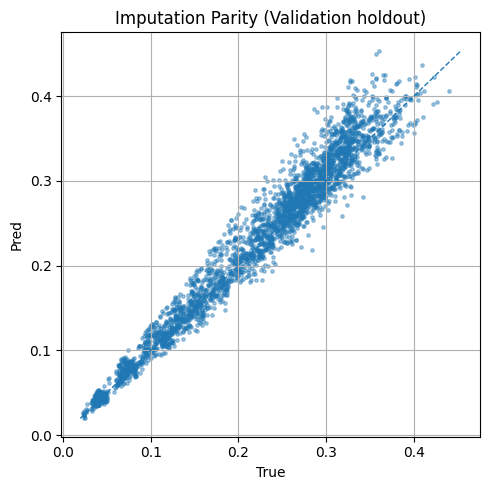

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_parity_test.png


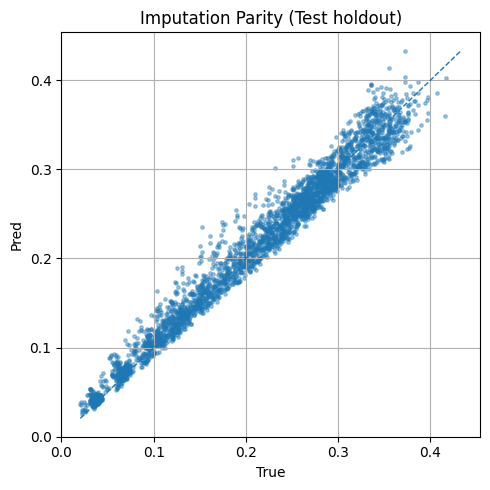

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_preview_1.png


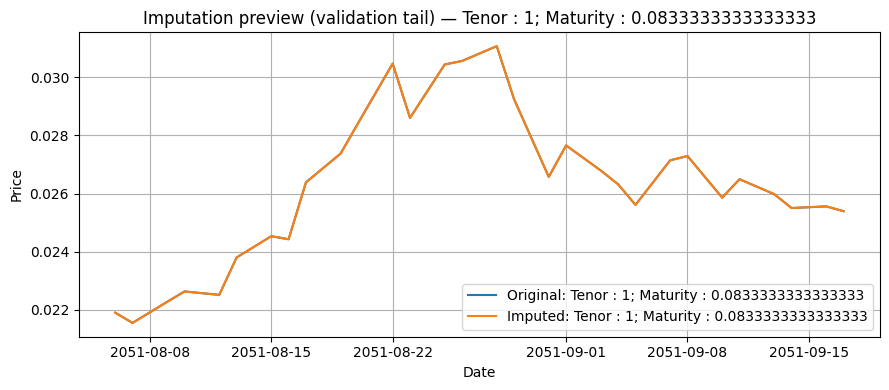

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_preview_2.png


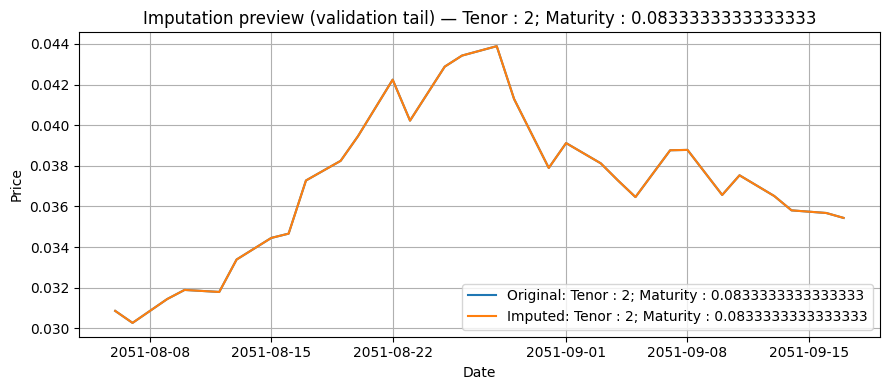

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_preview_3.png


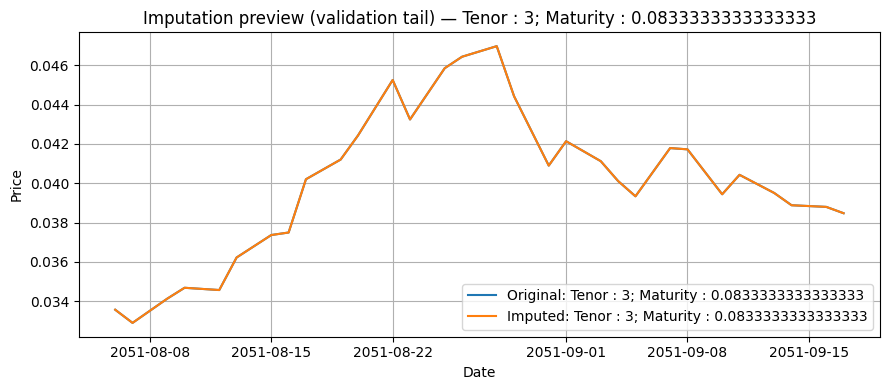

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\imputed_swaption_qrc.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_test_H14.png


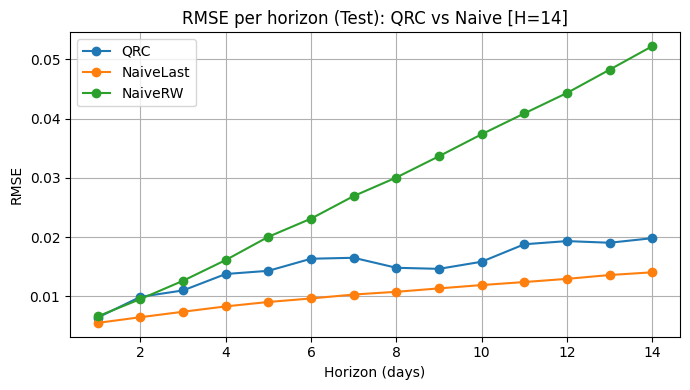

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_val_H14.png


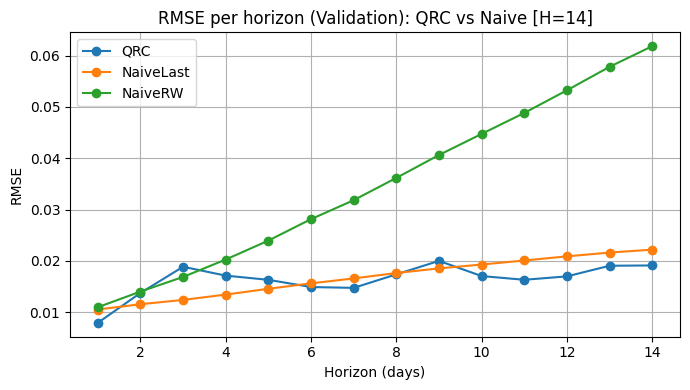

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_overlay_QRC_vs_Naive_h1_H14.png


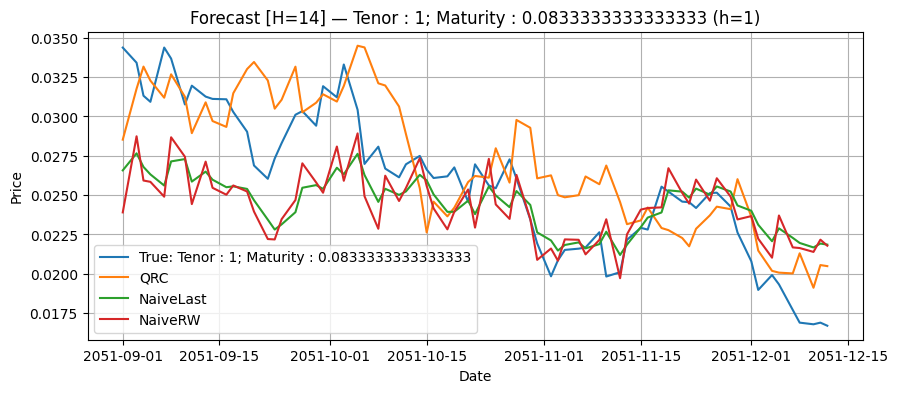

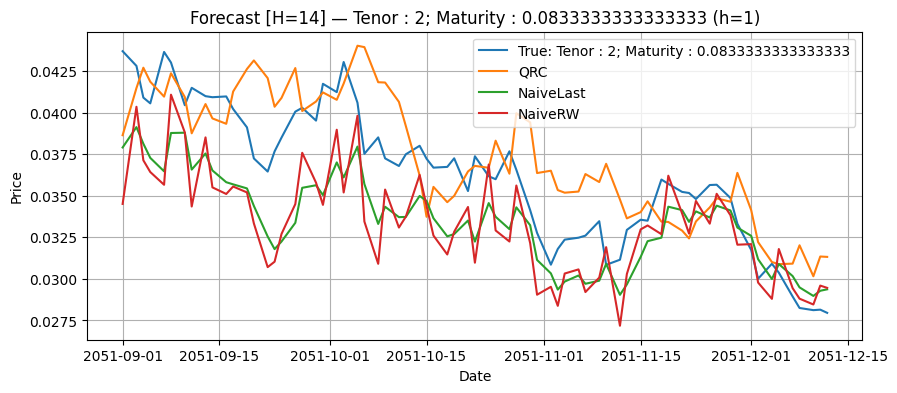

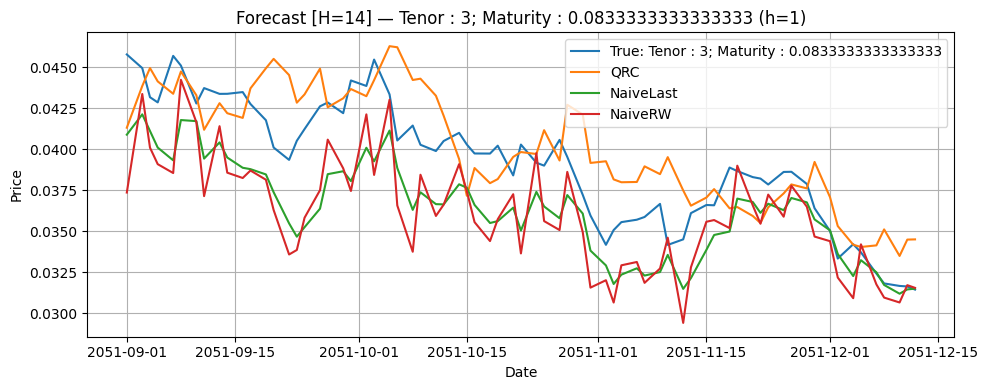

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_overlay_QRC_vs_Naive_h14_H14.png


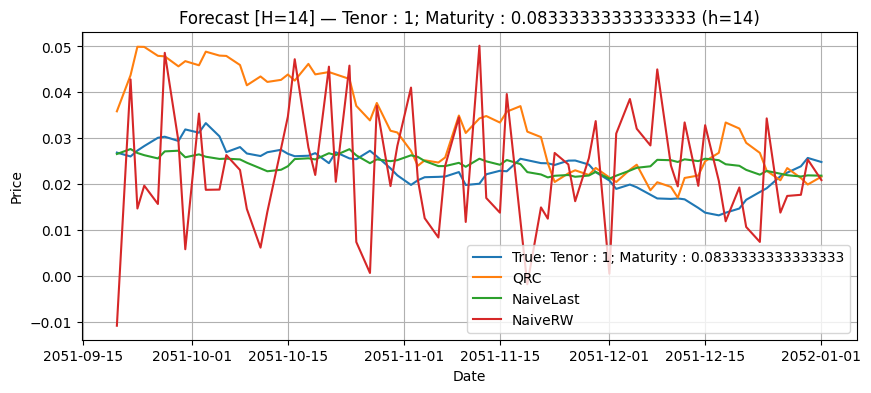

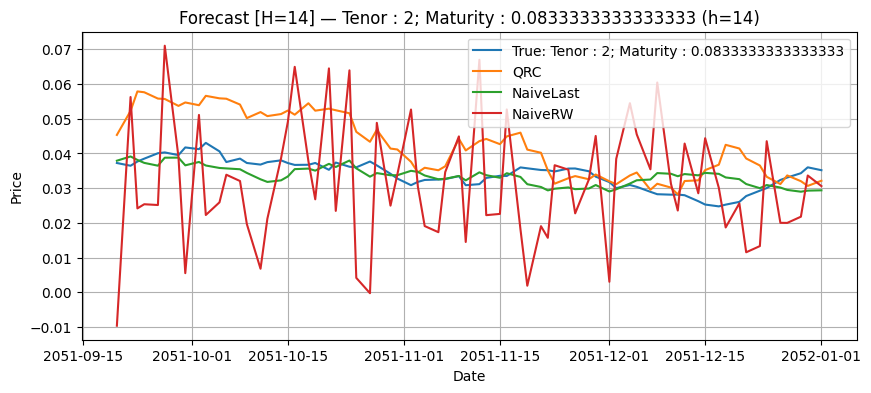

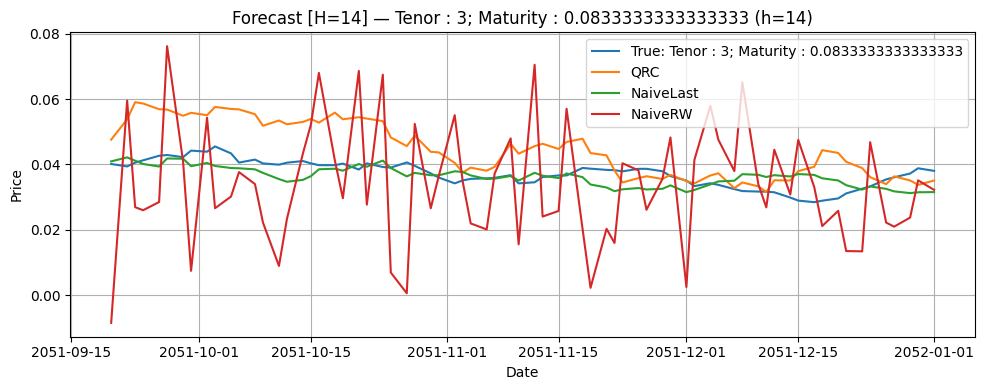

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_parity_h1_H14.png


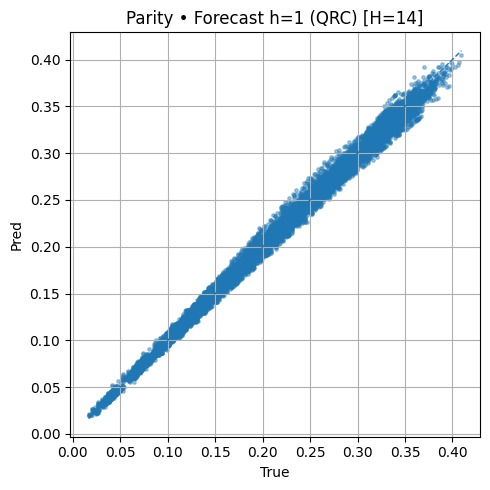

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_err_hist_h1_H14.png


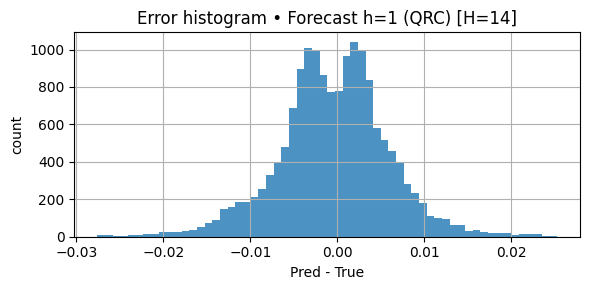

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_rmse_heatmap_h1_H14.png


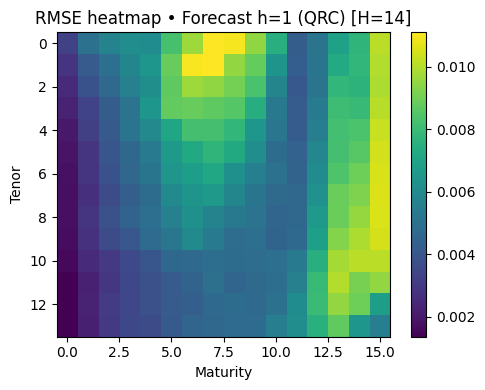

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_test_H3.png


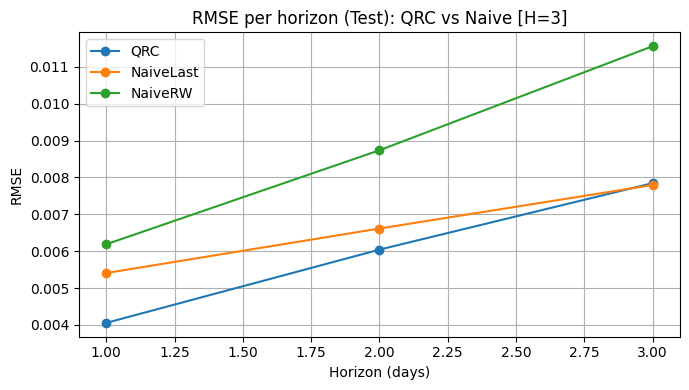

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_val_H3.png


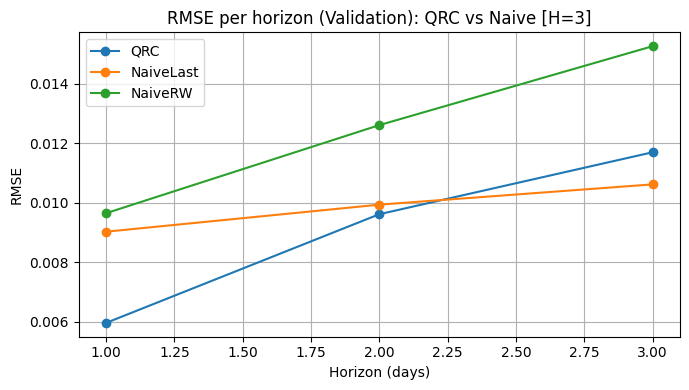

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_overlay_QRC_vs_Naive_h1_H3.png


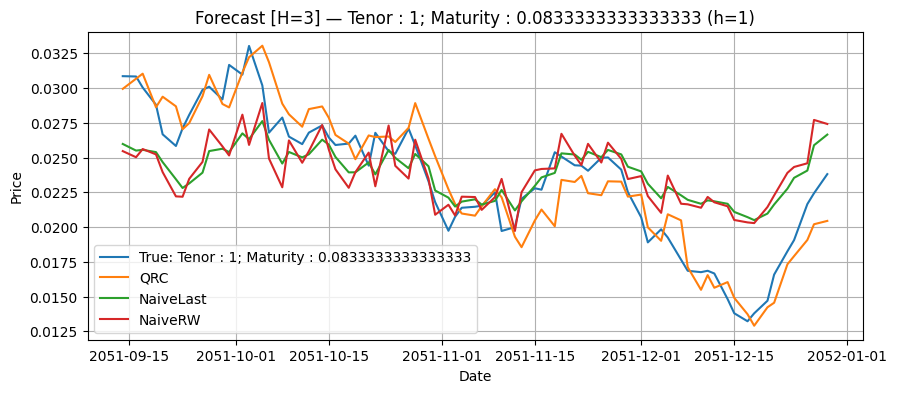

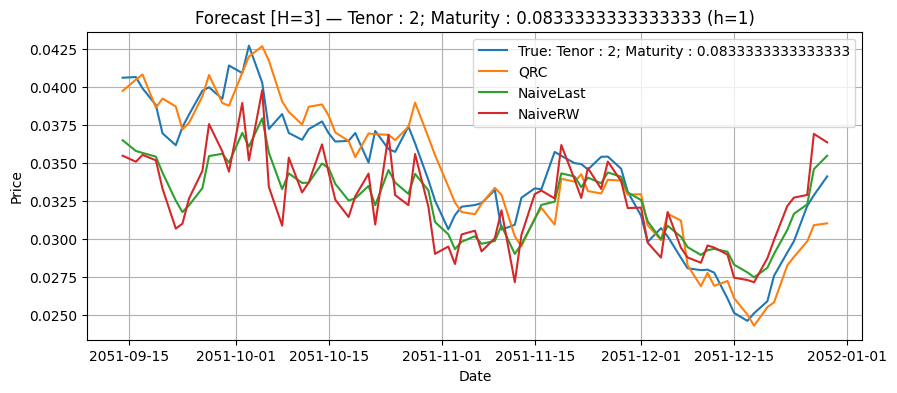

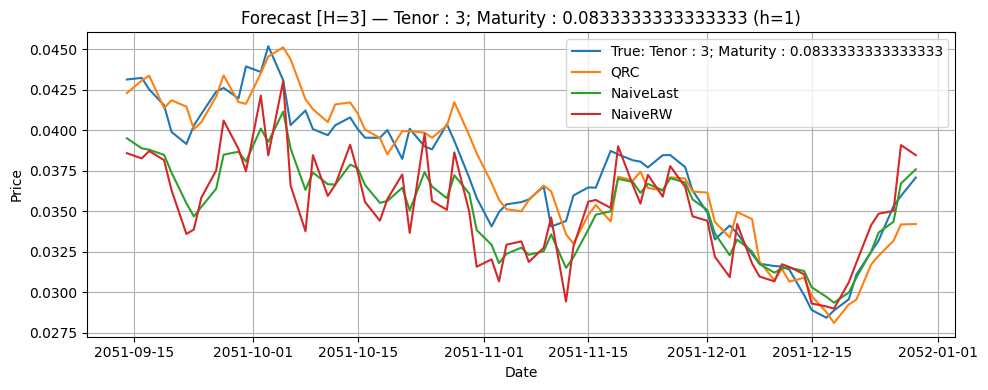

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_overlay_QRC_vs_Naive_h3_H3.png


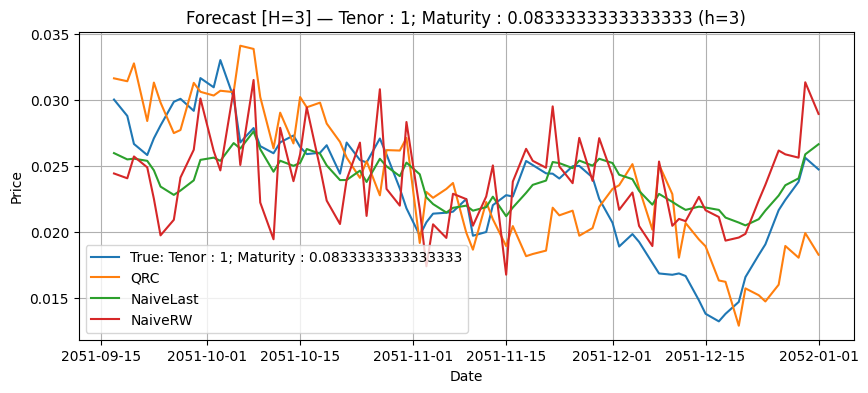

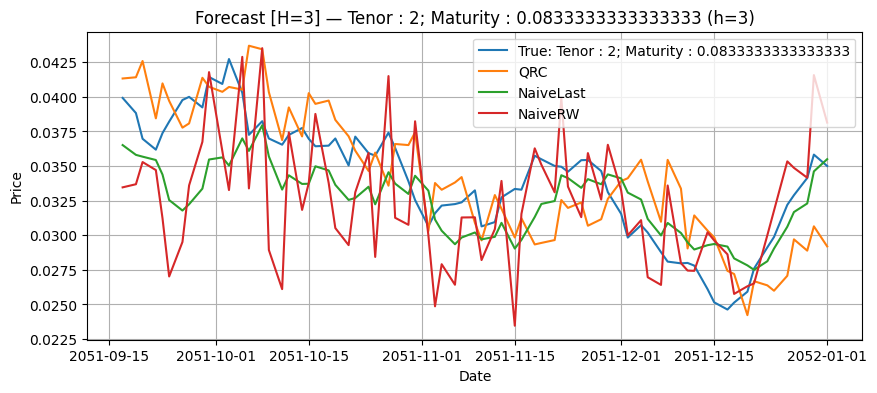

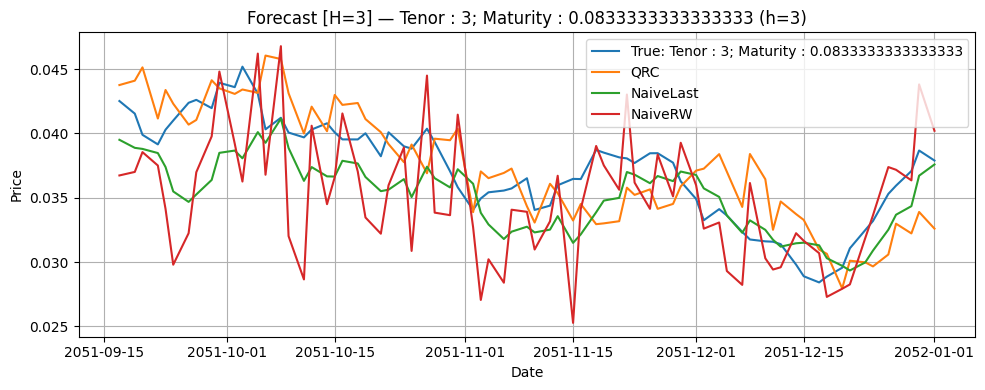

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_parity_h1_H3.png


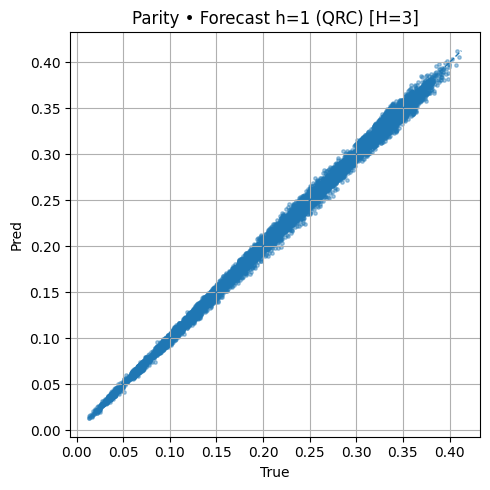

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_err_hist_h1_H3.png


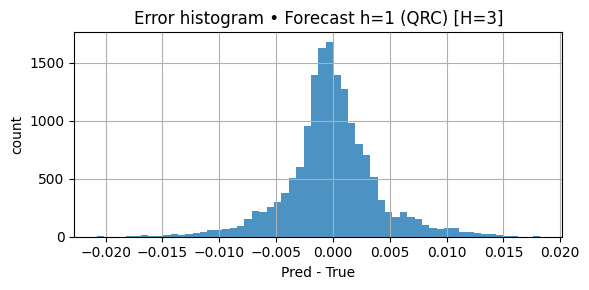

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_rmse_heatmap_h1_H3.png


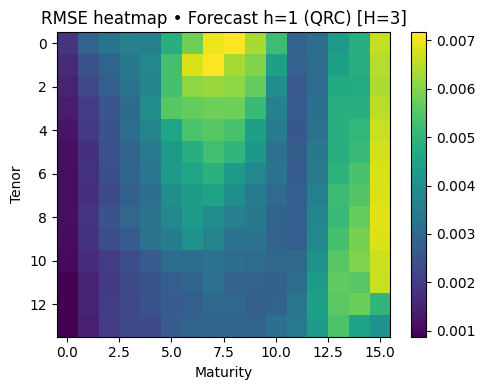

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_model_bar_H14.png


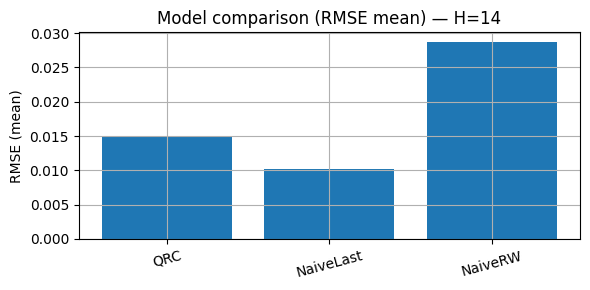

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_model_bar_H3.png


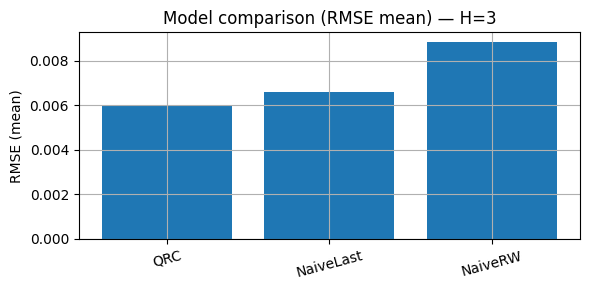


=== SUMMARY ===
Imputation: QRC vs Prev-day (RMSE, Test) = 0.016556 vs 0.003360
Forecast(H=14): Test RMSE mean — QRC=0.015031, Last=0.010260, RW=0.028685
Forecast(H=3): Test RMSE mean — QRC=0.005982, Last=0.006607, RW=0.008829
[Note] qubits=6, depth=2, use_pair=False; EXOG file=found


In [3]:
# ================================
# Cell 3 — 結果表示・保存（Imputation と Forecast[H=14,H=3]）
# ================================
outdir = OUTDIR

# --- A) 欠損補完 ---
print("\n[A] Imputation — masked metrics")
print(f" Val  QRC  RMSE={ART_IMP['val_masked']['RMSE']:.6f} (n={ART_IMP['val_masked']['count']})")
print(f" Val  Prev RMSE={ART_IMP['val_masked_baseline']['RMSE']:.6f}")
print(f" Test QRC  RMSE={ART_IMP['test_masked']['RMSE']:.6f} (n={ART_IMP['test_masked']['count']})")
print(f" Test Prev RMSE={ART_IMP['test_masked_baseline']['RMSE']:.6f}")

# 散布図（Val/Test）
parity_plot(ART_IMP["true_val_holdout"].reshape(-1,1), ART_IMP["pred_val_holdout"].reshape(-1,1),
            title="Imputation Parity (Validation holdout)")
savefig(os.path.join(outdir, "fig_impute_parity_val.png"))
parity_plot(ART_IMP["true_test_holdout"].reshape(-1,1), ART_IMP["pred_test_holdout"].reshape(-1,1),
            title="Imputation Parity (Test holdout)")
savefig(os.path.join(outdir, "fig_impute_parity_test.png"))

# Val末尾プレビュー（3系列）
val_dates = ART_IMP["dates_all"][ (W + ART_IMP["idx_val"].start) : (W + ART_IMP["idx_val"].stop) ]
dates_preview = val_dates[-30:]
df_true_like = pd.DataFrame({"Date": pd.to_datetime(df[DATE_COL].values), **{c: df[c].values for c in ART_IMP["imputed_df"].columns if c!="Date"}})
df_imp_like  = ART_IMP["imputed_df"].copy()
for i in range(3):
    col = ART_IMP["imputed_df"].columns[1+i]
    plt.figure(figsize=(9,4))
    s1 = df_true_like.loc[df_true_like["Date"].isin(dates_preview)][col].values
    s2 = df_imp_like.loc[df_imp_like["Date"].isin(dates_preview)][col].values
    plt.plot(dates_preview, s1, label=f"Original: {col}")
    plt.plot(dates_preview, s2, label=f"Imputed: {col}")
    plt.title(f"Imputation preview (validation tail) — {col}")
    plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.grid(True)
    savefig(os.path.join(outdir, f"fig_impute_preview_{i+1}.png"))

ART_IMP["imputed_df"].to_csv(os.path.join(outdir, "imputed_swaption_qrc.csv"), index=False)
print(f"[SAVE] {os.path.join(outdir, 'imputed_swaption_qrc.csv')}")

# --- B) 将来予測（H=14, H=3） ---
for H in [14, 3]:
    FC = ART_FC[H]
    # RMSE vs horizon（Val/Test）
    plot_rmse_vs_h(FC["df_te"],  title=f"RMSE per horizon (Test): QRC vs Naive [H={H}]")
    savefig(os.path.join(outdir, f"fig_forecast_rmse_vs_h_test_H{H}.png"))
    plot_rmse_vs_h(FC["df_val"], title=f"RMSE per horizon (Validation): QRC vs Naive [H={H}]")
    savefig(os.path.join(outdir, f"fig_forecast_rmse_vs_h_val_H{H}.png"))

    # 折れ線の重ね書き（h=1 と 末端h）
    plot_forecast_overlay_with_baselines(
        FC["dates_by_h"], FC["true_te"], FC["pred_te"], FC["last_te"], FC["rw_te"], FC["feature_cols"],
        horizon_idx=0, top_k=3, title_prefix=f"Forecast [H={H}]"
    )
    savefig(os.path.join(outdir, f"fig_overlay_QRC_vs_Naive_h1_H{H}.png"))

    plot_forecast_overlay_with_baselines(
        FC["dates_by_h"], FC["true_te"], FC["pred_te"], FC["last_te"], FC["rw_te"], FC["feature_cols"],
        horizon_idx=(H-1), top_k=3, title_prefix=f"Forecast [H={H}]"
    )
    savefig(os.path.join(outdir, f"fig_overlay_QRC_vs_Naive_h{H}_H{H}.png"))

    # Parity / Error hist / RMSE heatmap（h=1）
    y_true_h1 = FC["true_te"][:, 0, :]
    y_pred_h1 = FC["pred_te"][:, 0, :]
    parity_plot(y_true_h1, y_pred_h1, title=f"Parity • Forecast h=1 (QRC) [H={H}]")
    savefig(os.path.join(outdir, f"fig_parity_h1_H{H}.png"))
    error_hist(y_true_h1, y_pred_h1, title=f"Error histogram • Forecast h=1 (QRC) [H={H}]")
    savefig(os.path.join(outdir, f"fig_err_hist_h1_H{H}.png"))
    rmse_heatmap_by_grid(y_true_h1, y_pred_h1, FC["feature_cols"], title=f"RMSE heatmap • Forecast h=1 (QRC) [H={H}]")
    savefig(os.path.join(outdir, f"fig_rmse_heatmap_h1_H{H}.png"))

# --- C) モデル横比較バー（平均RMSE） ---
plot_model_bar(ART_MODEL["H14"], title="Model comparison (RMSE mean) — H=14",
               out_png=os.path.join(outdir, "fig_model_bar_H14.png"))
plot_model_bar(ART_MODEL["H3"],  title="Model comparison (RMSE mean) — H=3",
               out_png=os.path.join(outdir, "fig_model_bar_H3.png"))

# --- D) SUMMARY ---
print("\n=== SUMMARY ===")
print(f"Imputation: QRC vs Prev-day (RMSE, Test) = {ART_IMP['test_masked']['RMSE']:.6f} vs {ART_IMP['test_masked_baseline']['RMSE']:.6f}")
for H in [14,3]:
    print(f"Forecast(H={H}): Test RMSE mean — QRC={ART_FC[H]['df_te']['QRC']['RMSE'].mean():.6f}, "
          f"Last={ART_FC[H]['df_te']['NaiveLast']['RMSE'].mean():.6f}, RW={ART_FC[H]['df_te']['NaiveRW']['RMSE'].mean():.6f}")
print(f"[Note] qubits={N_QUBITS}, depth={DEPTH}, use_pair={USE_PAIR}; EXOG file={'found' if len(used_exog_cols)>0 else 'not found/unused'}")
